In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from nn import Layer, FeedForwardNN, WeightInitializationOption, WeightInitializer, Activation, xavier_std
from optimizers import RMSProp, StochasticGradientDescent, Adam
from metrics import mean_squared_error_loss
from sklearn.model_selection import train_test_split


# Universal Function Approximation

In [2]:
class FuncApproximator:
    """
    A class to approximate a scalar function using a FeedForward Neural Network.

    Attributes:
        model (FeedForwardNN): The neural network model to be trained.
        scalar_func (callable): The function to be approximated.
        x (np.ndarray): The input data points.
        y (np.ndarray): The output data points corresponding to x.
    """

    def __init__(self, model: FeedForwardNN, scalar_func: callable, x: np.ndarray, y: np.ndarray):
        """
        Initializes the FuncApproximator.

        Args:
            model (FeedForwardNN): An instance of the FeedForwardNN class.
            scalar_func (callable): The scalar function to approximate.
            x (np.ndarray): An array of input values.
            y (np.ndarray): An array of output values from the scalar_func.
        """
        self.model = model
        self.scalar_func = scalar_func
        self.x = x
        self.y = y
        self.y_pred = None  # To store predictions after fitting

    def fit(self, batch_size: int, test_split_size: float, epochs: int, display_on_each_n_step: int, learning_rate: float = 0.001):
        """
        Trains the neural network model to approximate the function.

        Args:
            batch_size (int): The number of samples per batch.
            test_split_size (float): The proportion of the dataset to include in the validation split.
            epochs (int): The number of epochs to train for.
            display_on_each_n_step (int): How often to display training progress.
            learning_rate (float, optional): The learning rate for the optimizer. Defaults to 0.001.
        """
        # Reshape data for train_test_split
        X_data_reshaped = self.x.reshape(-1, 1)

        # Split data into training and validation sets
        X_train_np, X_val_np, y_train_np, y_val_np = train_test_split(
            X_data_reshaped, self.y, test_size=test_split_size, random_state=42
        )

        # Convert to list of lists for X and list for y, as expected by FeedForwardNN
        X_train = X_train_np.tolist()
        y_train = y_train_np.tolist()
        X_val = X_val_np.tolist()
        y_val = y_val_np.tolist()

        # Choose Optimizer and Loss
        params = self.model.parameters()
        optimizer = Adam(parameters=params, lr=learning_rate)
        loss_fn = mean_squared_error_loss

        # Fit the model
        self.model.fit(
            X_train=X_train,
            y_train=y_train,
            optimizer=optimizer,
            loss=loss_fn,
            epochs=epochs,
            batch_size=batch_size,
            metric="mse",
            X_val=X_val,
            y_val=y_val,
            display_each_n_step=display_on_each_n_step
        )
        
        # After fitting, we can generate the predictions for visualization
        self._predict_full_range()

    def _predict_full_range(self):
        """Helper method to predict y values for the entire range of x."""
        X_full_for_prediction = [[val] for val in self.x]
        y_pred_values_nested = self.model.forward_batch(x=X_full_for_prediction)
        
        # Extract the scalar value from the output
        self.y_pred = np.array([val[0].val for val in y_pred_values_nested])


    def visualize_fit(self):
        """
        Visualizes the original function and the neural network's approximation.
        """
        if self.y_pred is None:
            print("Model has not been fitted yet. Please call the 'fit' method first.")
            return

        plt.figure(figsize=(12, 7))
        plt.plot(self.x, self.y, label='True Function', color='blue', linewidth=2)
        plt.plot(self.x, self.y_pred, label='NN Approximation', color='red', linestyle='--', alpha=0.7)
        plt.title('Neural Network Approximation of a Function')
        plt.xlabel('x')
        plt.ylabel('f(x)')
        plt.grid(True)
        plt.legend(fontsize=12)
        plt.axhline(0, color='black', linewidth=0.5)
        plt.axvline(0, color='black', linewidth=0.5)
        plt.show()

## Approximate Function 1

**Let's use Multilayer Perceptron to learn approximation for this function on interval $[0, 15]$**

$f(x) = -0.03 \cdot x^2 \cdot 0.05 \cdot \ln(x^3) + 0.5 \cdot \cos\left(\frac{x}{1.5}\right) + 0.1 \cdot \sin(5x)$


2025-07-17 13:18:05.175 | INFO     | nn:fit:428 - Epoch 1/40  train_loss=4.4204  mse: 4.420436866088436    val_loss=2.9184  val_mse=2.9184
2025-07-17 13:18:09.963 | INFO     | nn:fit:428 - Epoch 5/40  train_loss=2.3290  mse: 2.3289960012912956    val_loss=1.2093  val_mse=1.2093
                                   2025-07-17 13:18:16.838 | INFO     | nn:fit:428 - Epoch 10/40  train_loss=0.8747  mse: 0.8747333095059852    val_loss=0.3705  val_mse=0.3705
2025-07-17 13:18:23.262 | INFO     | nn:fit:428 - Epoch 15/40  train_loss=0.5056  mse: 0.5056342132095875    val_loss=0.1598  val_mse=0.1598
2025-07-17 13:18:30.048 | INFO     | nn:fit:428 - Epoch 20/40  train_loss=0.2031  mse: 0.2031063140028412    val_loss=0.0618  val_mse=0.0618
2025-07-17 13:18:36.678 | INFO     | nn:fit:428 - Epoch 25/40  train_loss=0.1237  mse: 0.12372924053012659    val_loss=0.0375  val_mse=0.0375
2025-07-17 13:18:43.809 | INFO     | nn:fit:428 - Epoch 30/40  train_loss=0.0464  mse: 0.04637086877679107    val_loss=0.

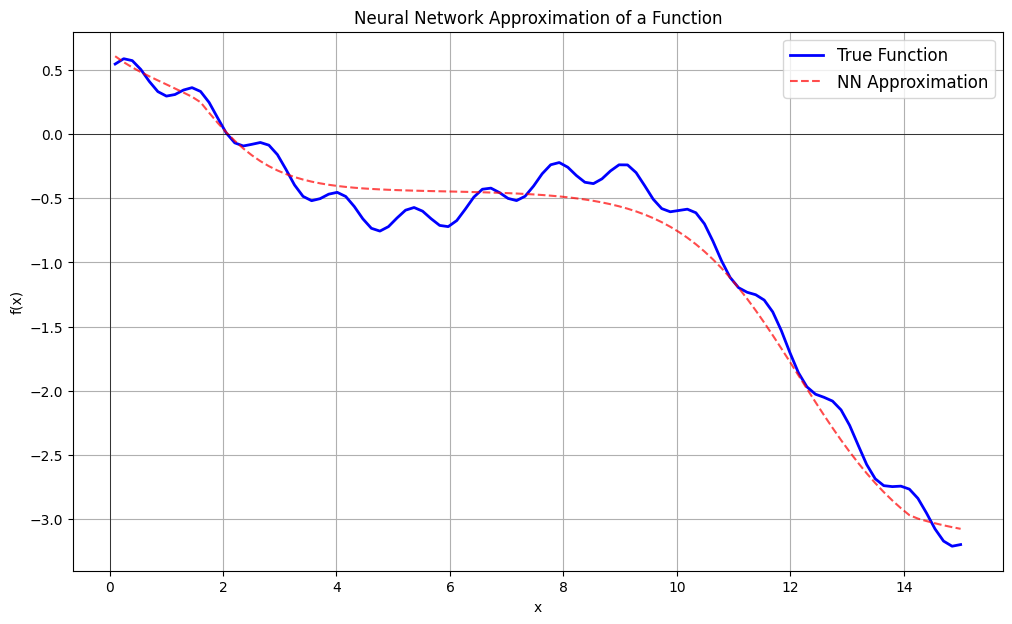

In [3]:
def complicated_function(x):
    return -0.03 * x**2  * 0.05 * np.log(x ** 3) + 0.5 * np.cos(x/1.5) + 0.1 * np.sin(x*5)

x_values = np.linspace(0.1, 15, 100)
y_values = complicated_function(x_values)

model = FeedForwardNN(
    layers=[
        Layer(
            n_input=1,
            n_output=24, 
            activation=Activation.TANH,
            initializer=WeightInitializer(option=WeightInitializationOption.NORMAL, sd=xavier_std(1, 16))
        ),
        Layer(
            n_input=24,
            n_output=8, 
            activation=Activation.TANH,
            initializer=WeightInitializer(option=WeightInitializationOption.NORMAL, sd=xavier_std(16, 8))
        ),
        Layer(
            n_input=8,
            n_output=8, 
            activation=Activation.RELU,
            initializer=WeightInitializer(option=WeightInitializationOption.NORMAL, sd=xavier_std(8, 8))
        ),
        Layer(
            n_input=8,
            n_output=1, 
            activation=Activation.LINEAR,
            initializer=WeightInitializer(option=WeightInitializationOption.NORMAL, sd=xavier_std(8, 1))
        )
    ]
)

approximator1 = FuncApproximator(
    model=model,
    scalar_func=complicated_function,
    x=x_values,
    y=y_values
)
approximator1.fit(
    batch_size=8,
    test_split_size=0.1,
    epochs=40,
    display_on_each_n_step=5,
    learning_rate=0.004
)
approximator1.visualize_fit()

## Approximate Function 2


                                   2025-07-17 13:20:35.817 | INFO     | nn:fit:428 - Epoch 1/40  train_loss=0.0920  mse: 0.09199802610832855    val_loss=0.0258  val_mse=0.0258
2025-07-17 13:20:42.062 | INFO     | nn:fit:428 - Epoch 2/40  train_loss=0.0326  mse: 0.03264133054623754    val_loss=0.0183  val_mse=0.0183
2025-07-17 13:20:49.413 | INFO     | nn:fit:428 - Epoch 3/40  train_loss=0.0248  mse: 0.024778161894151052    val_loss=0.0183  val_mse=0.0183
2025-07-17 13:20:58.341 | INFO     | nn:fit:428 - Epoch 4/40  train_loss=0.0219  mse: 0.021932486808101725    val_loss=0.0140  val_mse=0.0140
                                   2025-07-17 13:21:09.065 | INFO     | nn:fit:428 - Epoch 5/40  train_loss=0.0202  mse: 0.020245260253408538    val_loss=0.0196  val_mse=0.0196
2025-07-17 13:21:16.050 | INFO     | nn:fit:428 - Epoch 6/40  train_loss=0.0205  mse: 0.020530088092833448    val_loss=0.0164  val_mse=0.0164
2025-07-17 13:21:24.253 | INFO     | nn:fit:428 - Epoch 7/40  train_loss=0.0187 

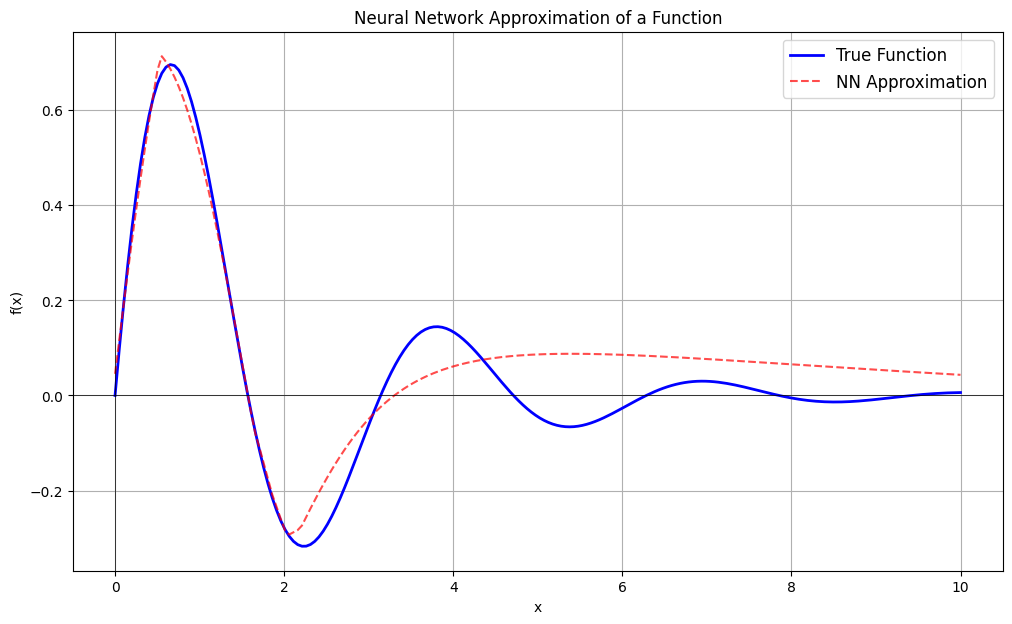

In [4]:
def dampened_wave_function_2(x):
    """
    A function that represents a dampened wave.
    """
    return np.exp(-0.5 * x) * np.sin(x * 2)

x_values_2 = np.linspace(0, 10, 200)  # Using more points for a smoother curve
y_values_2 = dampened_wave_function_2(x_values_2)

model_2 = FeedForwardNN(
    layers=[
        Layer(
            n_input=1,
            n_output=32,  # Increased neurons for more complexity
            activation=Activation.TANH,
            initializer=WeightInitializer(option=WeightInitializationOption.NORMAL, sd=xavier_std(1, 32))
        ),
        Layer(
            n_input=32,
            n_output=16,
            activation=Activation.TANH,
            initializer=WeightInitializer(option=WeightInitializationOption.NORMAL, sd=xavier_std(32, 16))
        ),
        Layer(
            n_input=16,
            n_output=16,
            activation=Activation.RELU,
            initializer=WeightInitializer(option=WeightInitializationOption.NORMAL, sd=xavier_std(16, 16))
        ),
        Layer(
            n_input=16,
            n_output=1,
            activation=Activation.LINEAR,
            initializer=WeightInitializer(option=WeightInitializationOption.NORMAL, sd=xavier_std(16, 1))
        )
    ]
)

approximator2 = FuncApproximator(
    model=model_2,
    scalar_func=dampened_wave_function_2,
    x=x_values_2,
    y=y_values_2
)

approximator2.fit(
    batch_size=8,
    test_split_size=0.15,
    epochs=40,  # Increased epochs for better fitting
    display_on_each_n_step=1,
    learning_rate=0.005
)

approximator2.visualize_fit()